<h1>CS4618: Artificial Intelligence I</h1>
<h1>The Normal Equation for OLS Regression</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from ipywidgets import interactive

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import add_dummy_feature

import numpy.linalg as npla

In [3]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "." 

<h1>Linear Regression</h1>
<ul>
    <li>Recap:
        <ul>
            <li>The learner is given a labeled training set ($m \times n$ matrix $\v{X}$ and 
                $m$-dimensional vector $\v{y}$) and it inserts an extra element $\v{x}_0^{(i)}$ in each
                row $i$, all of which will be 1
                $$\v{X} = \begin{bmatrix}
                    \v{x}_0^{(1)} = 1 & \v{x}_1^{(1)} & \v{x}_2^{(1)} & \ldots & \v{x}_n^{(1)} \\
                    \v{x}_0^{(2)} = 1 & \v{x}_1^{(2)} & \v{x}_2^{(2)} & \ldots & \v{x}_n^{(2)} \\
                    \vdots            & \vdots        & \vdots        & \vdots & \vdots \\
                    \v{x}_0^{(m)} = 1 & \v{x}_1^{(m)} & \v{x}_2^{(m)} & \ldots & \v{x}_n^{(m)} \\
                          \end{bmatrix}\,\,\,\,
                   \v{y} = \cv{y^{(1)}\\ y^{(2)}\\ \vdots\\ y^{(m)}}
                 $$
             </li>
             <li>An $n$-dimensional column vector 
                 $\v{\beta} = \cv{\v{\beta}_0\\ \v{\beta}_1\\ \vdots\\ \v{\beta}_n}$
                 gives us a hypothesis $h_{\v{\beta}}$ where
                 $$\hat{y} = h_{\v{\beta}}(\v{x}) = \v{x}\v{\beta}$$
             <li>In the case of Ordinary Least Squares (OLS) regression, we must find the vector $\v{\beta}$
                 that minimizes the following loss function
                 $$J(\v{X}, \v{y}, \v{\beta}) = \frac{1}{2m}\sum_{i=1}^m(h_{\v{\beta}}(\v{x}^{(i)}) - \v{y}^{(i)})^2$$
             </li>
             <li>In Machine Learning, the variables whose values we are trying to find (in this case, $\v{\beta}$)
                are called the <b>parameters</b>.
             </li>
         </ul>
     </li>
    <li>How does linear regression find the best model? In other words, how does it find the best $\v{\beta}$?</li>
</ul>

In [4]:
# Loss function for OLS regression (assumes X contains all 1s in its first column)
def J(X, y, beta):
    return np.mean((X.dot(beta) - y) ** 2) / 2.0

<h1>2D Visualization of $J$</h1>
<ul>
    <li>Let's visualize $J$ using the Cork Property Prices Dataset as the training set.</li>
    <li>For a 2D visualization, we'll assume that $\v{\beta}_j = 0$ for all $j$ except $j = 1$.
        <ul>
            <li>In other words, we are pretending that floor area is the only relevant feature.
            </li>
        </ul>
        Then we can plot $J$ on the vertical axis against different values of
        $\v{\beta}_{1}$ on the horizontal axis.
    </li>
</ul>

In [6]:
# Use pandas to read the CSV file
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_corkA.csv"))

# Get the feature-values (just flarea) and the target values 
X = df[["flarea"]].values
y = df["price"].values

In [7]:
def show_linear_model_and_loss(beta1):
    fig = plt.figure(figsize=(8, 4)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.title("Training set")
    plt.xlabel("Floor area (sq metres)")
    plt.xlim(-500, 500)
    plt.ylabel("Price (000 euros)")
    plt.ylim(0, 1000)

    ax1 = plt.subplot(gs[1])
    plt.title("Loss function")
    plt.xlabel("$beta1$")
    plt.xlim(-10, 10)
    plt.ylabel("$J$")
    plt.ylim(0, 1500000)
    
    fig.tight_layout()
    
    ax0.scatter(df["flarea"], df["price"], color = 'green')
    xvals = np.linspace(-500, 500, 3)
    ax0.plot(xvals, xvals * beta1, color = "blue")
    ax1.scatter(beta1, J(X, y, beta1), color = "red")

    plt.show()
    
interactive_plot = interactive(show_linear_model_and_loss, beta1=(-10,10,.1))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='beta1', max=10.0, min=-10.0), Output()), _dom_classe…

<h2>Another 2D Visualization of $J$</h2>
<ul>
    <li>Instead of making manual adjustments, let's use a loop to try several values for $\v{\beta}_1$</li>
</ul>

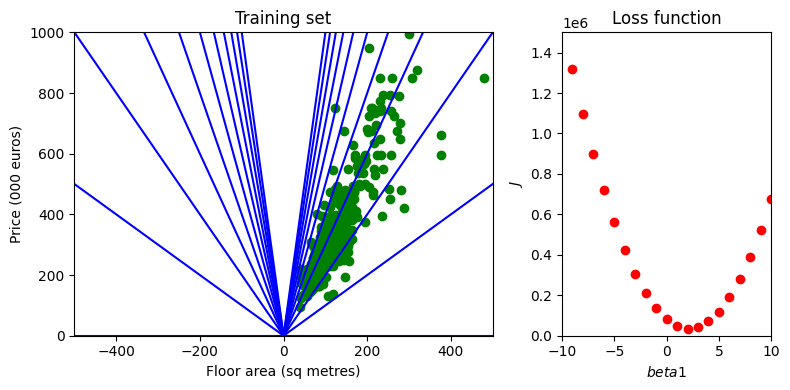

In [8]:
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax0 = plt.subplot(gs[0])
plt.title("Training set")
plt.xlabel("Floor area (sq metres)")
plt.xlim(-500, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
ax1 = plt.subplot(gs[1])
plt.title("Loss function")
plt.xlabel("$beta1$")
plt.xlim(-10, 10)
plt.ylabel("$J$")
plt.ylim(0, 1500000)
fig.tight_layout()
ax0.scatter(df["flarea"], df["price"], color = 'green')

xvals = np.linspace(-500, 500, 3)
beta1s = np.linspace(-10, 10, 21)

for beta1 in beta1s:
    ax0.plot(xvals, xvals * beta1, color = "blue")

ax1.scatter(beta1s, [J(X, y, beta1) for beta1 in beta1s], color = "red")

plt.show()

<ul>
    <li>The loss function is <b>convex</b>.</li>
    <li>Informally, this means:
        <ul>
            <li>
                in 2D, it is u-shaped;
            </li>
            <li>
                it has a unique minimum.
            </li>
        </ul>
    </li>
    <li>This is no accident: it follows from the way the loss function has been defined.</li>
    <li>(To be 100% accurate: there is a unique minimum provided no feature in $\v{X}$ is linearly dependent on any of the others or, equivalently, provided $\v{X}$ has an inverse.)</li>
</ul>

<h2>3D Visualization of $J$</h2>
<ul>
    <li>Let's visualize $J$ again using the Cork Property Prices Dataset as the training set.</li>
    <li>This time, we'll assume that $\v{\beta}_j = 0$ for all $j$ except $j = 2$ and $j = 3$.
        <ul>
            <li>In other words, we are pretending that the number of bedrooms and bathrooms are the only relevant 
               features.
            </li>
        </ul>
        This will be a 3D plot with $J$ on the vertical axis against different values of $\v{\beta}_2$ 
        and $\v{\beta}_3$ on the horizontal axes.
    </li>
</ul>

In [9]:
X = df[["bdrms", "bthrms"]].values
y = df["price"].values 

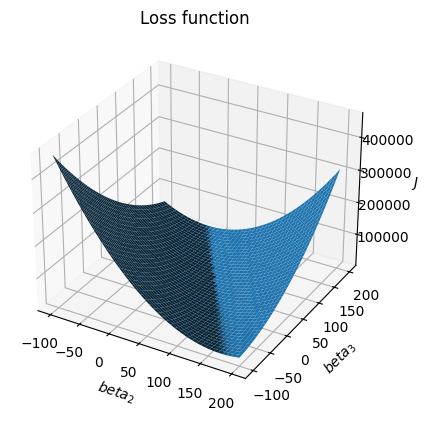

In [10]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Loss function")
ax.set_xlabel("$beta_2$")
ax.set_ylabel("$beta_3$")
ax.set_zlabel("$J$")
xvals = np.linspace(-100, 200, 301)
yvals = np.linspace(-100, 200, 301)
xxvals, yyvals = np.meshgrid(xvals, yvals)
zs = np.array([J(X, y, [beta2, beta3]) for beta2, beta3 in zip(xxvals.flatten(), yyvals.flatten())])
zvals = zs.reshape(xxvals.shape)
ax.plot_surface(xxvals, yyvals, zvals)
plt.show()

<h2>Another Visualization of $J$</h2>
<ul>
    <li>Here is the same data that we had in 3D but on a different kind of plot, called a <b>contour plot</b>.</li>
    <li>In effect, it flattens the diagram above.</li>
    <li>The lines connect points that have the same value for $J$.</li>
</ul>

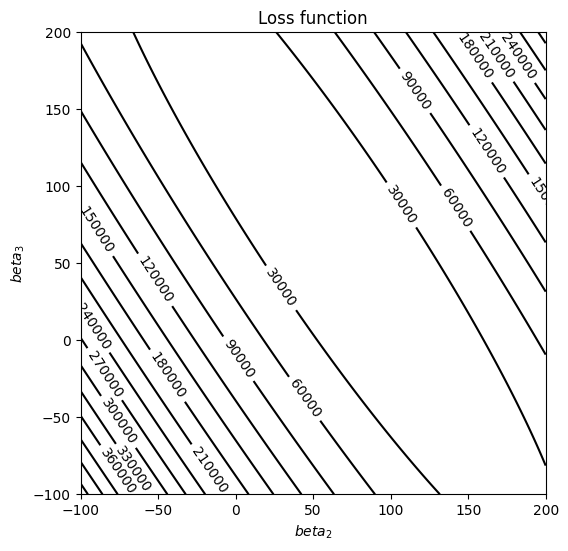

In [11]:
fig = plt.figure(figsize = (6, 6)) 
plt.title("Loss function")
plt.xlabel("$beta_2$")
plt.ylabel("$beta_3$")
xvals = np.linspace(-100, 200, 301)
yvals = np.linspace(-100, 200, 301)
xxvals, yyvals = np.meshgrid(xvals, yvals)
zs = np.array([J(X, y, [beta2, beta3]) for beta2, beta3 in zip(xxvals.flatten(), yyvals.flatten())])
zvals = zs.reshape(xxvals.shape)
C = plt.contour(xxvals, yyvals, zvals, 15, colors = "black")
plt.clabel(C, inline=1, fontsize=10)
plt.show()

<ul>
    <li>The 3D visualization and the contour plot show that this too is convex.</li>
    <li>Informally, this means:
        <ul>
            <li>
                in 3D it is bowl-shaped;
            </li>
            <li>
                again there is a unique minimum.
            </li>
        </ul>
    </li>
</ul>

<h1>Ordinary Least Squares Linear Regression</h1>
<ul>
    <li>How do we find the best values for $\v{\beta}$?</li>
    <li>There are two methods:
        <ul>
            <li>The Normal Equation; and</li>
            <li>Gradient Descent.</li>
        </ul>
    </li>
</ul>

<h1>The Normal Equation</h1>
<ul>
    <li>The <b>normal equation</b> solves for $\v{\beta}$:
        $$\v{\beta} = (\v{X}^T\v{X})^{-1}\v{X}^T\v{y}$$
        <ul>
            <li>In other words, the normal equation gives us the
                parameters that minimize the loss function.
            </li>
        </ul>
    </li>
    <li>Where does it come from?
        <ul>
            <li>Take the gradient of the loss function: $\frac{1}{m}\v{X}^T(\v{X}\v{\beta} - \v{y})$ (see next slide).</li>
            <li>Set it to zero: $\frac{1}{m}\v{X}^T(\v{X}\v{\beta} - \v{y}) = \v{0}$ (in fact, a
                $(n+1)$-dimensional vector of zeros).
            </li>
            <li>Then do some algebraic manipulation to get $\v{\beta}$ on the left-hand side:
                $\v{\beta} = (\v{X}^T\v{X})^{-1}\v{X}^T\v{y}$
            </li>
        </ul>
    </li>
</ul>

<h1>Partial Derivatives</h1>
<ul>
    <li>We need the <b>gradient</b> of the loss function with regards to each $\v{\beta}_j$.
        <ul>
            <li>In other words, how much the loss will change if we change $\v{\beta}_j$ a little.</li>
            <li>With respect to a particular $\v{\beta}_j$, it is called the <b>partial derivative</b>.
        </ul>
    </li>
    <li>Without doing the calculus, the partial derivatives of $J(\v{X}, \v{y}, \v{\beta})$ with respect to
        $\v{\beta}_j$ are
        $$\frac{\partial J(\v{X}, \v{y}, \v{\beta})}{\partial\v{\beta}_j} = 
          \frac{1}{m}\sum_{i=1}^m(\v{x}^{(i)}\v{\beta}_j - \v{y}^{(i)}) \times \v{x}_j^{(i)}$$
    </li>
    <li>The <b>gradient vector</b>, $\nabla_{\v{\beta}}J(\v{X}, \v{y}, \v{\beta})$, is a vector
        of each partial derivative:
        $$\nabla_{\v{\beta}}J(\v{X}, \v{y}, \v{\beta}) = 
            \cv{\frac{\partial J(\v{X}, \v{y}, \v{\beta})}{\partial\v{\beta}_0}\\ 
              \frac{\partial J(\v{X}, \v{y}, \v{\beta})}{\partial\v{\beta}_1}\\ 
              \vdots\\ 
              \frac{\partial J(\v{X}, \v{y}, \v{\beta})}{\partial\v{\beta}_n}} =
              \cv{\frac{1}{m}\sum_{i=1}^m(\v{x}^{(i)}\v{\beta}_0 - \v{y}^{(i)}) \times \v{x}_0^{(i)}\\
                \frac{1}{m}\sum_{i=1}^m(\v{x}^{(i)}\v{\beta}_1 - \v{y}^{(i)}) \times \v{x}_1^{(i)}\\
                \vdots\\
                \frac{1}{m}\sum_{i=1}^m(\v{x}^{(i)}\v{\beta}_n - \v{y}^{(i)}) \times \v{x}_n^{(i)}}
        $$
     </li>
     <li>And there is a vectorized way to compute it:
         $$\nabla_{\v{\beta}}J(\v{X}, \v{y}, \v{\beta}) = \frac{1}{m}\v{X}^T(\v{X}\v{\beta} - \v{y})$$
     </li>
</ul>

<h1>The Normal Equation in scikit-learn</h1>
<ul>
    <li>The <code>fit</code> method of scikit-learn's <code>LinearRegression</code> class does
        what we have described:
        <ul>
            <li>It inserts the extra column of 1s.</li>
            <li>It calculates $\v{\beta}$ using the Normal Equation.</li>
        </ul>
    </li>
</ul>

<h1>The Normal Equation in numpy</h1>
<ul>
    <li>For the hell of it, let's see how to implement it ourselves.</li>
    <li>Again for the purposes of this explanation, we will use the entire dataset as our training set.
        <ul>
            <li>We have learned that using <em>all</em> the data for training is usually not
                the right thing to do.
            </li>
        </ul>
    </li>
</ul>

In [12]:
# Get the feature-values and the target values 
X = df[["flarea", "bdrms", "bthrms"]].values
y = df["price"].values

# Add the extra column to X
X = add_dummy_feature(X)

# Solve the normal equation
beta = npla.inv(X.T.dot(X)).dot(X.T).dot(y)

# Display beta
beta

array([38.17496491,  2.49923248, -0.32659509,  0.78080337])

<ul>
    <li>Essentially, one line of code!</li>
    <li>But there's a problem:
        <ul>
            <li>The normal equation requires that $\v{X}^T\v{X}$ has an inverse.</li>
            <li>But it might not (see earlier lecture about matrices).</li>
        </ul>
        When we discussed this before, we mentioned that, in some cases, we can use the 
        <em>pseudo-inverse</em> instead.
        <ul>
            <li>This is one of those cases.</li>
        </ul>
    </li>
    <li>So the more robust way of writing this program is:
</ul>

In [13]:
# Solve the normal equation - but using the pseudo-inverse
beta = npla.pinv(X.T.dot(X)).dot(X.T).dot(y)

# Display beta
beta

array([38.17496491,  2.49923248, -0.32659509,  0.78080337])